# 2.1 Realizácia predspracovania dát (5b).

### (A-1b) Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len **s trénovacím datasetom**.


In [242]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from pathlib import Path
from sklearn.model_selection import train_test_split
folder = Path("./070")

### Dáta si načítame

In [243]:
connections_df = pd.read_csv(folder / "connections.csv", delimiter="\t", parse_dates=['ts'])
devices_df = pd.read_csv(folder / "devices.csv", delimiter="\t")
processes_df = pd.read_csv(folder / "processes.csv", delimiter="\t", parse_dates=['ts'])
profiles_df = pd.read_csv(folder / "profiles.csv", delimiter="\t")

## Zlúčenie dát z rôznych tabuliek

Tabuľky majú spoločný atribút, a tým je **imei**, ten ale nie je unikátny, a tak potrebujeme ďalší atribút na spojenie tabuľky. Unikátny kľúč, podľa ktorého by sme mohli tabuľky spojiť, je **imei + datetime + mwra**. Ak spojím tabuľky na základe týchto atribútov, dostaneme **validný merge**. Tieto dáta avšak nájdeme iba v datesetoch **connections.csv** a **processes.csv**, preto spojíme iba tieto tabuľky.

Dáta rozdelíme pomocou funkcie **train_test_split()** z sklearn.model v pomere $80$:$20$. **random_state** zaisťuje opakovateľnosť, aby sme mohli prípadne debuggovať.

In [244]:
merged_data = pd.merge(connections_df, processes_df, on=['imei', 'ts', 'mwra'], how='inner')

# este rozdelime cas na konkretne atributy, aby
# sme ich pripadne mohli pouzit v ML

# merged_data['year'] = merged_data['ts'].dt.year
# merged_data['month'] = merged_data['ts'].dt.month
# merged_data['day'] = merged_data['ts'].dt.day
# merged_data['hour'] = merged_data['ts'].dt.hour
# merged_data['day_of_week'] = merged_data['ts'].dt.dayofweek

# tieto data sme sa rozhodli nepridavat (vid 2.2 A))

print(merged_data.shape)
merged_data.head()


# potom splitnut merged data na 80 % trainning a 20% testing pomocou train_test_split
merged_train_df, merged_test_df = train_test_split(merged_data, test_size=0.2, random_state=42)


(15426, 33)


In [245]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12340 entries, 3784 to 7270
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          12340 non-null  datetime64[ns]
 1   imei                        12340 non-null  int64         
 2   mwra                        12340 non-null  float64       
 3   c.android.youtube           12340 non-null  float64       
 4   c.katana                    12340 non-null  float64       
 5   c.dogalize                  12340 non-null  float64       
 6   c.android.chrome            12340 non-null  float64       
 7   c.android.gm                12340 non-null  float64       
 8   c.UCMobile.x86              12340 non-null  float64       
 9   c.raider                    12340 non-null  float64       
 10  c.android.vending           12340 non-null  float64       
 11  c.updateassist              12340 non-null  float64      

### (B-1b) Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok. 


## Ako prvé si v mergnutom datasete určíme správne dátove typy

In [246]:
# function to find out mixed values in a column
def check_mixed_types(df):
    for column in df.columns:
        unique_types = df[column].apply(type).unique()
        if len(unique_types) > 1:
            print(f'Column: {column} has mixed types: {unique_types}')
        else:
            print(f'Column: {column} has only one type: {unique_types}')

check_mixed_types(merged_train_df)

Column: ts has only one type: [<class 'pandas._libs.tslibs.timestamps.Timestamp'>]
Column: imei has only one type: [<class 'int'>]
Column: mwra has only one type: [<class 'float'>]
Column: c.android.youtube has only one type: [<class 'float'>]
Column: c.katana has only one type: [<class 'float'>]
Column: c.dogalize has only one type: [<class 'float'>]
Column: c.android.chrome has only one type: [<class 'float'>]
Column: c.android.gm has only one type: [<class 'float'>]
Column: c.UCMobile.x86 has only one type: [<class 'float'>]
Column: c.raider has only one type: [<class 'float'>]
Column: c.android.vending has only one type: [<class 'float'>]
Column: c.updateassist has only one type: [<class 'float'>]
Column: c.UCMobile.intl has only one type: [<class 'float'>]
Column: p.android.chrome has only one type: [<class 'float'>]
Column: p.android.documentsui has only one type: [<class 'float'>]
Column: p.android.packageinstaller has only one type: [<class 'float'>]
Column: p.android.settings 

Vo výpise vidíme, že dátové typy sú **určené správne** a taktiež sú v **jednotnom formáte**.

## Identifikujeme a vyriešime (odstránime) duplikáty

In [247]:
def remove_duplicates(df):
    # v datasetoch sa nevyskytol prípad, kde by bol duplikátny sĺpec, a preto tu riešime iba riadky

    if len(df.loc[df.duplicated(), :]) > 0:
        df_dupless = df.loc[~df.duplicated(), :]
    
    return df_dupless

## Identifikujeme a vyriešime chýbajúce hodnoty

In [248]:
def has_missing_values(df):
    return df.isnull().any().any()


def count_missing_values(col):
    return col.isna().sum()


def replace_missing_values(col):
    # lets calculate the amount of outliers to determine, whether to use mean or median

    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1

    # lets identify the outliers
    outliers = ((col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR)))
    outliers_percentage = (outliers.sum() / col.count()) * 100

    if outliers_percentage < 5:
        return col.fillna(col.mean)
    else:
        return col.fillna(col.median)


def solve_missing_values(df):
    # if missing values < 5% => clip
    # if missing values >= 5% => replace with median
    # if missing values > 40% => drop column

    if not has_missing_values(df):
        print("there are no missing values")
        return df
    else:
        for column in df:
            total_rows = len(df)
            na_amount = count_missing_values(df[column])
            na_percentage = (na_amount/total_rows) * 100
            print(f'percentage: {column}: {na_percentage}%')

            # the missing values are making smaller amount than 5% so we clip them
            if na_percentage < 5:
                df = df.dropna(subset=[column])
            # the missing values will be replaced
            elif na_percentage >= 5 and na_percentage <= 40:
                df[column] = replace_missing_values(df[column])
            # there is too much missing values, lets drop the column
            else:
                df.drop(column, axis=1, inplace=True)
                print(f'dropped: {column}')
    return df


In [249]:
solve_missing_values(merged_data)

there are no missing values


,ts,imei,mwra,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.gm,c.UCMobile.x86,c.raider,...,p.katana,p.google,p.notifier,p.android.defcontainer,p.android.vending,p.inputmethod.latin,p.simulator,p.olauncher,p.browser.provider,p.gms.persistent
0,2018-05-05 10:00:00,3590433799317661057,1.0,12.57832,15.81566,11.44041,7.54471,8.14947,74.82810,98.66217,...,58.68759,46.55151,51.61852,36.47510,17.56601,87.35626,32.00305,69.51890,69.85184,21.51831
1,2018-05-05 10:01:00,3590433799317661073,0.0,14.53473,5.10559,13.23860,9.54599,12.96218,94.21770,33.36502,...,45.16131,34.43891,63.83929,72.42246,54.04621,35.68114,44.97550,84.71218,8.04137,76.74900
2,2018-05-05 10:02:00,863033069630348099,1.0,14.72129,13.76187,11.27464,16.56377,12.07414,73.70492,58.77622,...,59.91103,35.04185,32.01296,76.63106,38.55901,34.45914,86.26472,66.72859,75.20188,49.75180
3,2018-05-05 10:03:00,359043379931766007,1.0,14.17165,12.23936,8.53245,12.92046,12.97893,96.94804,65.95054,...,38.57900,38.61052,31.39066,16.12547,4.37465,90.40601,62.42150,18.49800,14.90605,14.40552
4,2018-05-05 10:04:00,8630330696303482071,1.0,14.52559,12.21164,10.68598,11.10452,11.09764,72.91827,69.47889,...,59.85793,50.84054,55.76454,48.84111,73.05974,97.77579,64.18499,78.20817,75.25798,0.55074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15421,2018-05-13 20:57:00,8630330696303481008,1.0,17.17673,10.07652,14.13618,14.82835,15.14615,78.19613,68.83968,...,50.82987,57.03723,60.99230,68.80162,52.96995,75.72684,42.28340,51.32429,95.70857,69.73254
15422,2018-05-14 01:17:00,3590433799317662188,0.0,15.96258,10.55080,11.27594,7.88137,10.30128,85.66285,24.44919,...,60.65804,53.67259,60.48345,44.49713,0.00498,82.00950,87.56227,88.34858,89.90047,21.42181
15423,2018-05-14 01:17:00,3590433799317662188,0.0,15.96258,10.55080,11.27594,7.88137,10.30128,85.66285,24.44919,...,60.65804,53.67259,60.48345,44.49713,0.00498,82.00950,87.56227,88.34858,89.90047,21.42181
15424,2018-05-10 23:25:00,3590433799317661198,1.0,13.02198,17.49888,14.75037,13.74212,10.38747,90.19126,5.84256,...,84.35493,53.06551,57.39217,36.38532,43.43760,51.47962,31.20808,67.90144,9.79193,38.18186


In [250]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]


def print_outliers_stat(df):
    for column in df:
        # Check if the column is numeric
        if pd.api.types.is_numeric_dtype(df[column]):
            outliers = identify_outliers(df[column])
            print(f'{column}: {len(outliers)} => {(len(outliers) * 100) / len(df[column]):.2f}%')


def remove_outliers(df):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=['number']).columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    
    return df_cleaned


def replace_outliers(df):
    # replace outliers with bounds, mean or median
    df_replaced = df.copy()

    for column in df_replaced.select_dtypes(include=['number']).columns:
        Q1 = df_replaced[column].quantile(0.25)
        Q3 = df_replaced[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        # replace with mean
        mean = df_replaced[column].mean()
        df_replaced[column] = np.where(df_replaced[column] > upper_bound, mean, df_replaced[column])
        df_replaced[column] = np.where(df_replaced[column] > upper_bound, mean, df_replaced[column])

        # replace with median
        #median = df_replaced[column].median()
        #df_replaced[column] = np.where(df_replaced[column] > upper_bound, mean, df_replaced[column])
        #df_replaced[column] = np.where(df_replaced[column] > upper_bound, mean, df_replaced[column])

        # replace with bounds
        #df_replaced[column] = np.where(df_replaced[column] > upper_bound, upper_bound, df_replaced[column])
        #df_replaced[column] = np.where(df_replaced[column] < lower_bound, lower_bound, df_replaced[column])

    return df_replaced

In [251]:
# toto bude pravdepodobne do tela funkcie replace_outliers

# toto je tu kvoli warningu
#processes_train['p.dogalize'] = processes_train['p.dogalize'].astype(float)


#Q1 = processes_train['p.dogalize'].quantile(0.25)
#Q3 = processes_train['p.dogalize'].quantile(0.75)
#IQR = Q3 - Q1
#lower_whisker = Q1 - 1.5 * IQR
#upper_whisker = Q3 + 1.5 * IQR
#median_value = processes_train['p.dogalize'].median()

#processes_train.loc[(processes_train['p.dogalize'] < lower_whisker) |
#                  (processes_train['p.dogalize'] > upper_whisker)] = median_value

#processes_train = remove_outliers(processes_train)
#print_outliers_stat(processes_train)

## Kódovanie kategórií do numerického formátu

Na enkódovanie kategórií by sme použili LabelEncoder pre atribúty s malým počtom kategórií a OneHotEncoder pre viacero kategórií. Naše mergnuté data sú už všetky atriúty numerické, takže toto netreba riešit v našom prípade.

In [252]:
merged_train_df.head()

,ts,imei,mwra,c.android.youtube,c.katana,c.dogalize,c.android.chrome,c.android.gm,c.UCMobile.x86,c.raider,...,p.katana,p.google,p.notifier,p.android.defcontainer,p.android.vending,p.inputmethod.latin,p.simulator,p.olauncher,p.browser.provider,p.gms.persistent
3784,2018-05-08 00:16:00,3590433799317661016,1.0,15.75402,11.35425,12.69769,13.98911,18.44522,36.33887,94.21625,...,61.30390,45.88740,45.15843,54.34515,29.70903,71.06763,44.12748,40.57806,86.56577,36.08712
13811,2018-05-14 21:32:00,8630330696303481305,0.0,17.83548,12.68519,12.33846,9.23900,11.54725,72.95152,46.56260,...,53.09412,36.06125,37.92394,92.71656,4.49703,46.40346,10.95631,54.73916,29.11742,67.40191
3128,2018-05-07 13:27:00,3590433799317661560,0.0,15.78895,9.66345,14.13034,11.18431,10.11198,50.86418,85.80315,...,68.17441,60.84868,43.79665,30.91028,1.84816,36.52292,8.24216,85.18883,33.75441,64.96796
1943,2018-05-06 17:56:00,3590433799317661628,0.0,14.23817,8.66162,9.99609,10.53535,11.59626,67.91198,6.68770,...,37.44178,15.83317,32.22974,32.85470,13.29446,27.19929,97.79050,38.84165,92.02711,35.75186
14285,2018-05-15 05:21:00,3590433799317661933,0.0,15.21157,15.27408,17.85337,12.50957,10.73088,24.81341,81.08148,...,54.84724,48.02914,53.24372,87.38758,14.08247,35.60950,17.58086,71.71708,37.63972,4.12313


## Merged data
Na merged dátach vidíme, že sú všetky atribúty numerické, a tak ich môžme všetky použiť v ML.

### (C-2b) Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze). 

# Import
Importujeme potrebné knižnice

In [253]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as pyplot
import seaborn as sns

# Save mwra
Predtým ako budeme škálovať dáta si odložíme našu predikovanú hodnotu mwra a v mergnutom datasete ju dropneme.

In [254]:
saved_mwra = merged_train_df['mwra']
merged_train_with_mwra = merged_train_df
merged_train_df = merged_train_df.drop(['mwra'], axis=1)

In [255]:
# TODO: CELE SKALOVANIE A TRANSFORM JE ZLE, TREBA SKALOVAT MERGED_TRAIN_DF
# A POTOM VYSLEDNY DF DAT DO TRANSFORMACIE A TAKTO VYTVORIT 4 KOMBINACIE A MAT 4 DATAFRAMY

In [256]:
# we will be using these 2 scalers and 2 transformers and we will create 4 combinations
scaler_standard = StandardScaler()
scaler_min_max = MinMaxScaler()
power_transformer = PowerTransformer()
quantile_transformer = QuantileTransformer()

- **StandardScaler** štandardizuje atribúty tak, že ich prevedie na distribúciu s priemerom 0 a štandardnou odchýlkou 1.
- **MinMaxScaler** škáluje atribúty do zvoleného rozsahu (napríklad 0 až 1)
- **PowerTransformer** využíva Box-Cox alebo Yeo-Johnson transformáciu na stabilizáciu rozdelenia.
- **QuantileTransformer** prevedie distribúciu dát na približne normálnu distribúciu pomocou kvantilov.

# 1. kombinácia škálovania a transformácie

In [257]:
# sp stands for standard scaler and power transformer
sp_data = merged_train_df.select_dtypes(include=[np.number]).copy()
sp_data = power_transformer.fit_transform(sp_data)
sp_data = scaler_standard.fit_transform(sp_data)
sp_data = pd.DataFrame(sp_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

# we have to add the mwra column back
sp_data['mwra'] = saved_mwra

# set mwra to be float
sp_data['mwra'] = sp_data['mwra'].astype(float)


# 2. kombinácia škálovania a transformácie

In [258]:
# sq stands for standard scaler and quantile transformer
sq_data = merged_train_df.select_dtypes(include=[np.number]).copy()
sq_data = scaler_standard.fit_transform(sq_data)
sq_data = quantile_transformer.fit_transform(sq_data)
sq_data
sq_data = pd.DataFrame(sq_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)


# 3. kombinácia škálovania a transformácie

In [259]:
# mp stands for min max scaler and power transformer
mp_data = merged_train_df.select_dtypes(include=[np.number]).copy()
mp_data = scaler_min_max.fit_transform(mp_data)
mp_data = power_transformer.fit_transform(mp_data)
mp_data
mp_data = pd.DataFrame(mp_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

# 4. kombinácia škálovania a transformácie

In [260]:
# mq stands for min max scaler and quantile transformer
mq_data = merged_train_df.select_dtypes(include=[np.number]).copy()
mq_data = scaler_min_max.fit_transform(mq_data)
mq_data = quantile_transformer.fit_transform(mq_data)
mq_data
mq_data = pd.DataFrame(mq_data, columns=merged_train_df.select_dtypes(include=[np.number]).columns)

<function matplotlib.pyplot.show(close=None, block=None)>

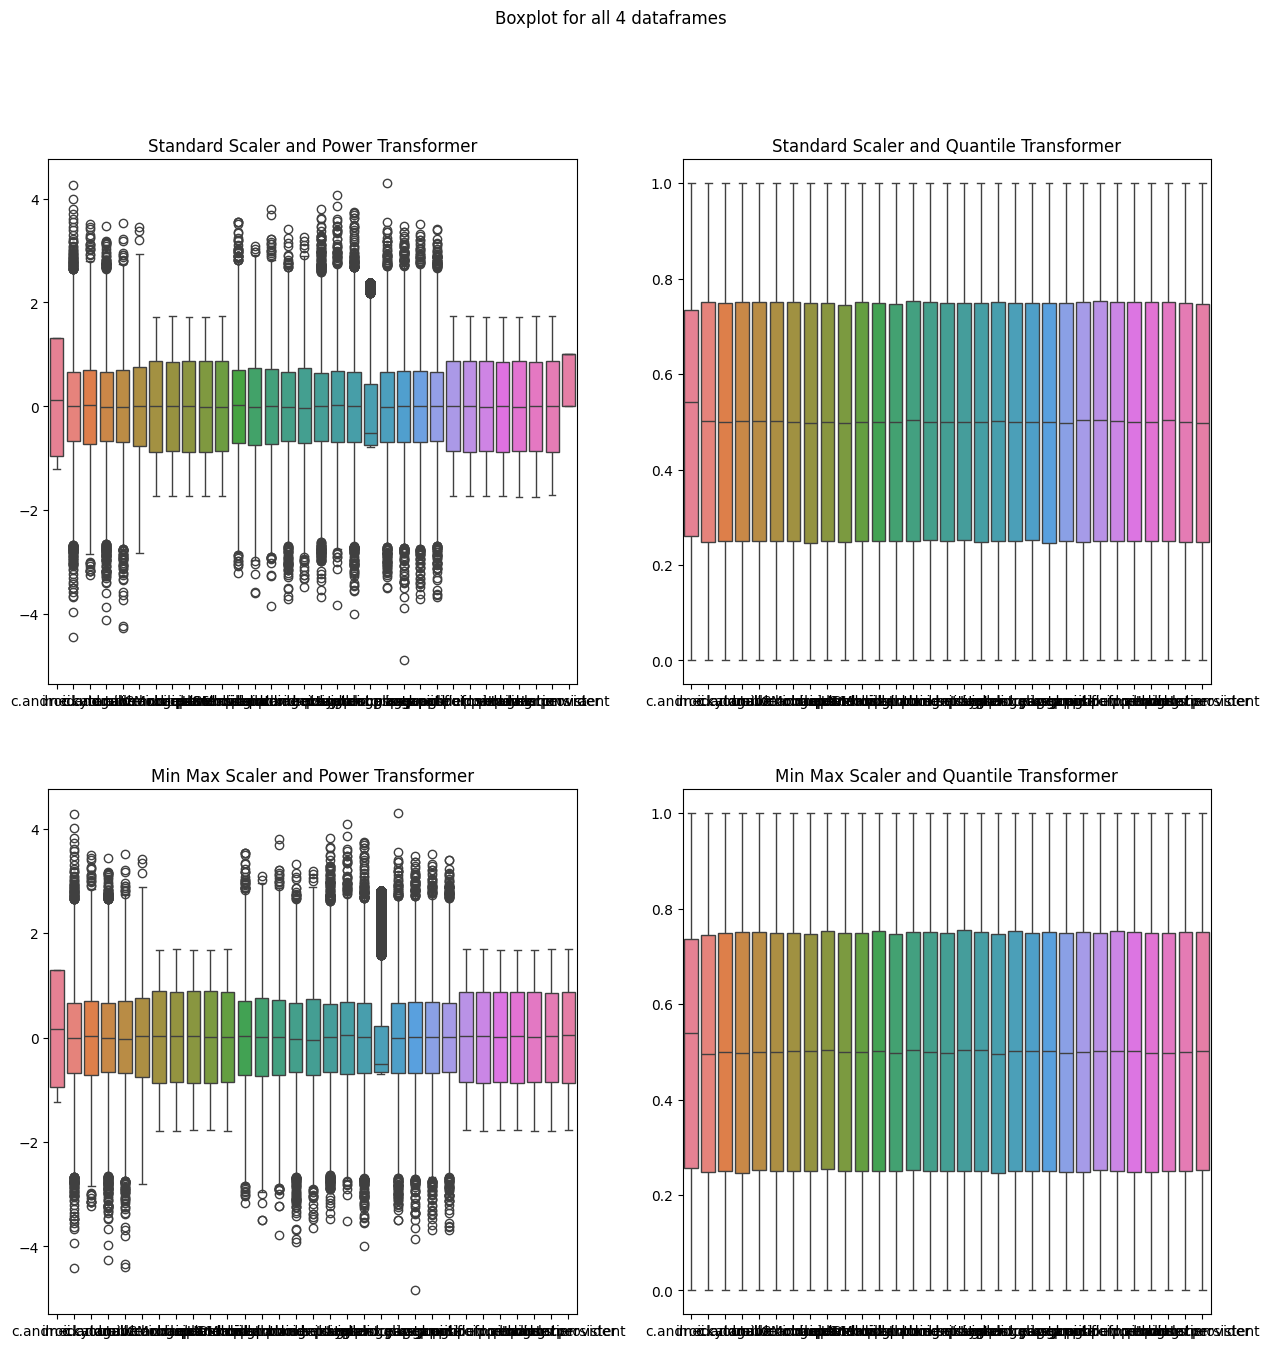

In [261]:
# TODO: tu by asi bolo fajn este pre kazdy df z tych 4 co budeme mat vykreslit spolocny graf
# npr boxplot vsetkych atributov a pozriet sa ci su fajn rozlozene po transformaci a scalingu
# 
# pripadne ak bude treba tak zmenit techniku transformovania (scaling techniky su vporiadku) 

# lets make a boxplot for all 4 dataframes
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Boxplot for all 4 dataframes')

sns.boxplot(data=sp_data, ax=axs[0,0])
axs[0, 0].set_title('Standard Scaler and Power Transformer')

sns.boxplot(data=sq_data, ax=axs[0,1])
axs[0, 1].set_title('Standard Scaler and Quantile Transformer')

sns.boxplot(data=mp_data, ax=axs[1,0])
axs[1,0].set_title('Min Max Scaler and Power Transformer')

sns.boxplot(data=mq_data, ax=axs[1,1])
axs[1,1].set_title('Min Max Scaler and Quantile Transformer')

plt.show

### (D-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)



# !!!!!! TODO !!!!!! TOTO ESTE SKONTROLOVAT A PREJST/PREPISAT

# Zdokumentovanie a Zdôvodnenie Rozhodnutí pri Transformácii Atribútov

Pri transformácii dát pre strojové učenie je dôležité zabezpečiť, aby atribúty mali vhodnú škálu, boli stabilné a aby ich distribúcia vyhovovala potrebám modelov. Nižšie je uvedené zdôvodnenie zvolených techník transformácie a škálovania.

## 1. Scaling (Škálovanie)
Výber techník škálovania bol motivovaný snahou o optimalizáciu výkonnosti modelov, ktoré často očakávajú normalizované alebo štandardizované vstupy.

### 1.1 StandardScaler
- **Dôvod**: StandardScaler bol zvolený, pretože štandardizuje atribúty na priemer 0 a štandardnú odchýlku 1, čo je vhodné pre algoritmy citlivé na rozsah dát, ako sú SVM, k-means alebo lineárna regresia.
- **Výhoda**: Táto metóda udržuje štatistickú vlastnosť rozdelenia dát a dobre funguje pre dáta, ktoré už majú približne normálne rozdelenie.

### 1.2 MinMaxScaler
- **Dôvod**: MinMaxScaler bol vybraný pre prípady, kde bolo nutné previesť dáta do jednotného rozsahu, napríklad 0 až 1, čo je dôležité pri metódach, ako sú neurónové siete, kde normalizácia atribútov zlepšuje konvergenciu.
- **Výhoda**: Škálovanie do konkrétneho rozsahu môže zvýšiť robustnosť algoritmu voči outlierom a zlepšiť interpretovateľnosť hodnoty každého atribútu.

## 2. Transformers (Transformácie)
Transformácie sme zvolili na stabilizáciu rozdelenia dát a odstránenie šikmosti (skewness), aby sa modely mohli lepšie zamerať na relevantné vzory.

### 2.1 PowerTransformer
- **Dôvod**: PowerTransformer bol zvolený pre svoje schopnosti stabilizovať rozdelenie dát pomocou Yeo-Johnson transformácie. Táto transformácia sa odporúča, ak sú atribúty pozitívne aj negatívne, pričom transformácia stabilizuje šikmosť a robí rozdelenie viac normálnym.
- **Výhoda**: Zlepšenie normality môže pomôcť modelom lineárneho typu a optimalizáciám, ktoré sa opierajú o normálne rozdelenie dát, ako sú regresné modely a PCA.

### 2.2 QuantileTransformer
- **Dôvod**: QuantileTransformer bol zvolený pre svoju schopnosť transformovať rozdelenie dát na normálnu distribúciu bez ohľadu na pôvodné rozdelenie, čo je užitočné pri atribútoch s výraznými odchýlkami.
- **Výhoda**: Táto metóda môže efektívne normalizovať dátové body a je vhodná pre modely citlivé na rozdelenie dát, ako sú algoritmy KNN alebo Bayesovské modely.

## 3. Kombinácia Transformácií v Pipeline
Pipeline bola zostavená na jednoduchšie testovanie a iteratívne kombinácie rôznych techník. Kombinovanie krokov zjednodušuje prácu a zabezpečuje konzistentnú predprípravu dát pre modelovanie.

- **Výhoda pipeline**: Pipeline podporuje opakovateľnosť a konzistenciu v prístupe k predspracovaniu dát. Týmto spôsobom môžeme efektívne otestovať rôzne kombinácie transformácií, vybrať najlepšie varianty a následne ich jednoducho aplikovať na nové dáta alebo testovaciu množinu.

## Celkové zdôvodnenie
Tieto voľby boli zamerané na optimalizáciu dát pre rôzne modely strojového učenia, od lineárnych metód po algoritmy citlivé na rozsah a rozdelenie dát. Skúmanie viacerých techník nám umožňuje prispôsobiť transformáciu atribútov tak, aby maximalizovala výkonnosť a presnosť modelu, čo je cieľom tejto fázy prípravy dát.


## 2.2 Výber atribútov pre strojové učenie (5b)

- (A-3b) Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou). 


In [262]:
# TODO: sem treba pridat tie 4 dataframes a na nich spravit 3 techniky identifikacie vztahu

# 1. dataframe

# 1. technika Korelačná matica pre dataframe č. 1
Korelačná matica identifikuje silu vzťahu medzi každým atribútom a cieľovou premennou. Pre číselné atribúty sa často využíva Pearsonova korelácia; vysoká hodnota (kladná alebo záporná) naznačuje informatívnosť atribútu pre predikciu.

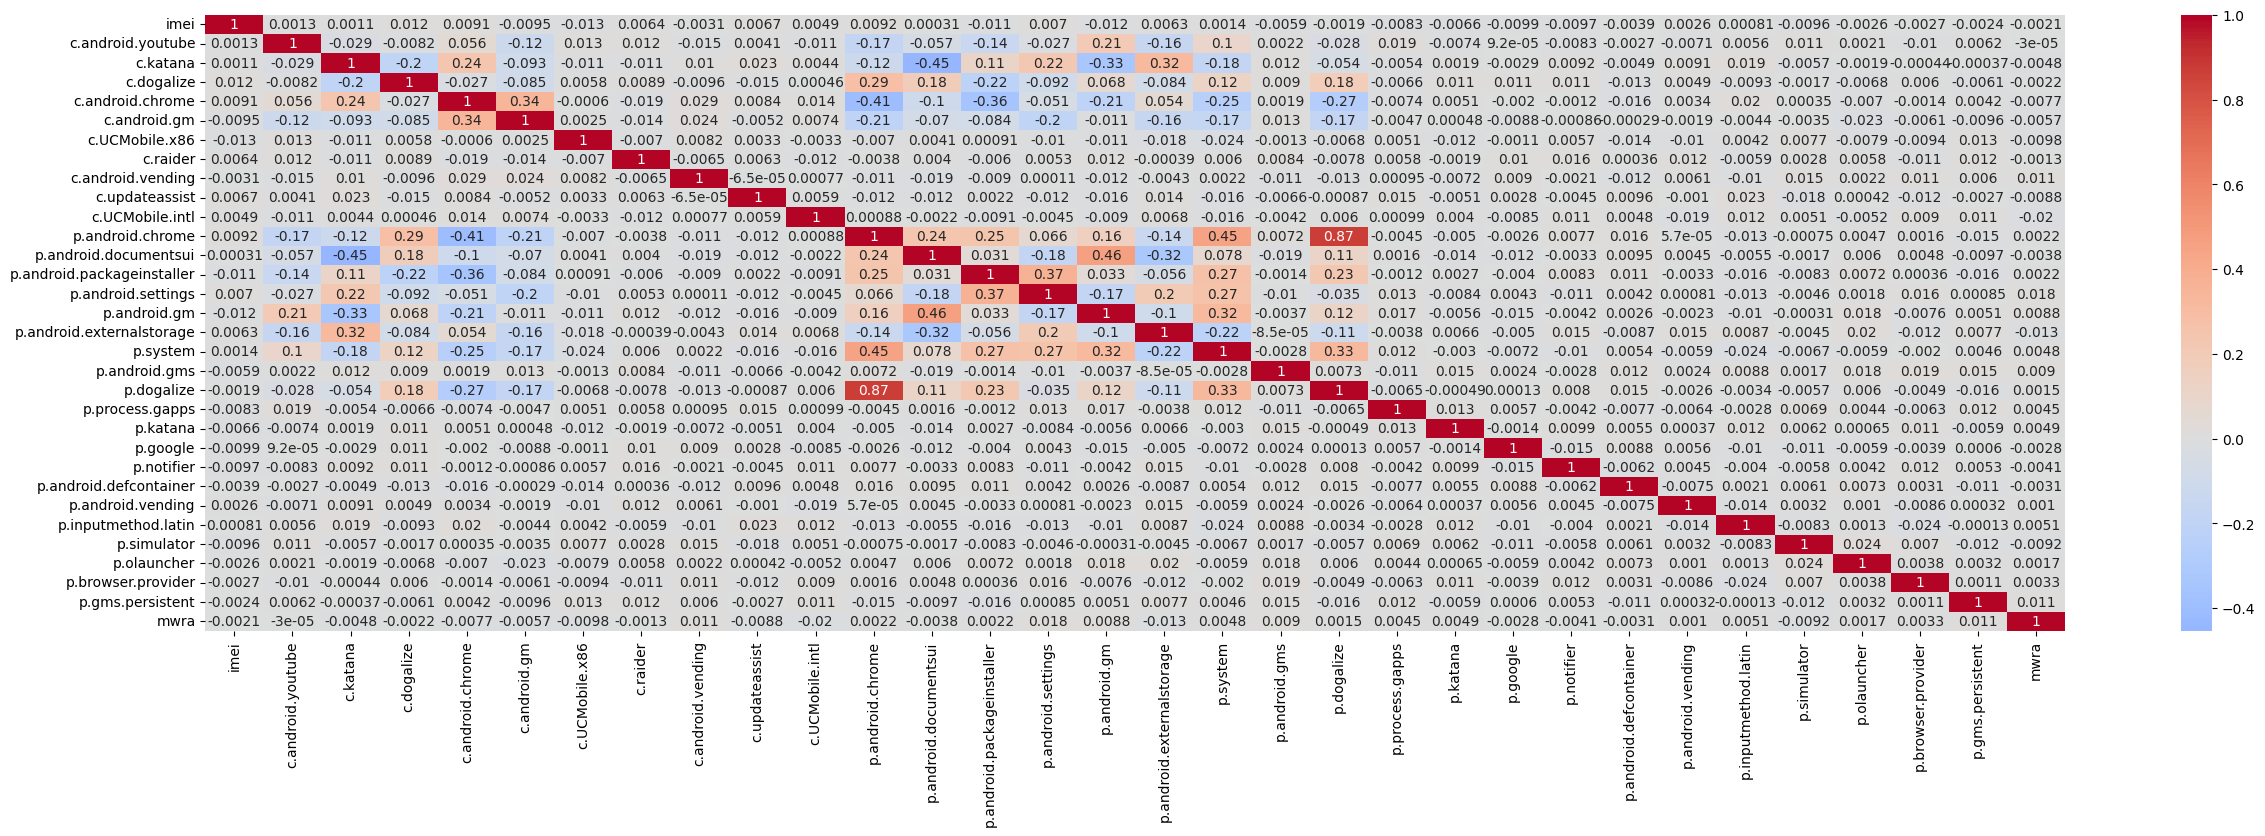

In [263]:
# we will use correlation matrix to identify the relationship between the features and the target variable mwra
# use it for the 4 dataframes

# Vytvorenie korelačnej matice
correlation_matrix = sp_data.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

korelacna matica je velmi velka, neprehladna a tazko citatelna, preto si vyberieme top 5 najvyssich hodnot k predikovanej premennej mwra

In [264]:
# Výber korelácie pre cieľový stĺpec 'mwra' a zoradenie podľa absolútnej hodnoty
top_5_features = correlation_matrix['mwra'].sort_values(key=abs, ascending=False).head(6)  # 'mwra' bude mať koreláciu 1 so sebou

# Odstránenie 'mwra' zo zoznamu
top_5_features = top_5_features.drop('mwra')

# Zobrazenie top 5 atribútov
print(top_5_features)

c.UCMobile.intl             -0.019705
p.android.settings           0.017738
p.android.externalstorage   -0.013411
c.android.vending            0.011325
p.gms.persistent             0.010547
Name: mwra, dtype: float64


vysledok korelacnej matice mozme vidiet top 5 atributov ktore pravdepodobne vplyvaju na atribut mwra

# 2. technika Random Forest
Použitím modelu Random Forest môžeme zistiť význam atribútov podľa toho, ako často a s akým dopadom sa daný atribút používa pri delení uzlov v rozhodovacích stromoch.

In [266]:
from sklearn.ensemble import RandomForestClassifier

# rozdelenie dataframu na dataframe ktory obsahuje iba mwra
# a taky v ktorom su ostatne atributy
X = sp_data.drop('mwra', axis=1)
y = sp_data['mwra']

# Tréning Random Forest modelu
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Zobrazenie významu atribútov
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Vizualizácia významu atribútov
feature_importances.plot(kind='barh', x='feature', y='importance', legend=False)
plt.show()

ValueError: Input y contains NaN.

Vysledok random forest mozme vidiet ze na predikciu mwra pravdepodobne vplyvaju atributy (od spodu nahor)

# 3. technika selektívne metóda s ANOVA
SelectKBest vyberá atribúty podľa štatistických testov. Pre klasifikačné úlohy sa často používa ANOVA alebo Chi-Square (Chi2) test. Táto metóda umožňuje identifikovať atribúty s najvyššou variabilitou voči cieľovej premennej. My pouzijeme Anovu pretoze mame numericke atributy, chi by sme pouzili pri kategorickych

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Použitie ANOVA pre numerické atribúty
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Získanie skóre a zoradenie atribútov podľa informatívnosti
scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_
}).sort_values(by='score', ascending=False)

# Vizualizácia najlepších atribútov podľa SelectKBest
scores.plot(kind='barh', x='feature', y='score', legend=False)
plt.show()

ValueError: Input y contains NaN.

Vysledok ANOVY mozme vidiet ze na predikciu mwra pravdepodobne vplyvaju atributy (od spodu nahor)

# 2. dataframe

# 1. technika Korelačná matica pre dataframe č. 1
Korelačná matica identifikuje silu vzťahu medzi každým atribútom a cieľovou premennou. Pre číselné atribúty sa často využíva Pearsonova korelácia; vysoká hodnota (kladná alebo záporná) naznačuje informatívnosť atribútu pre predikciu.

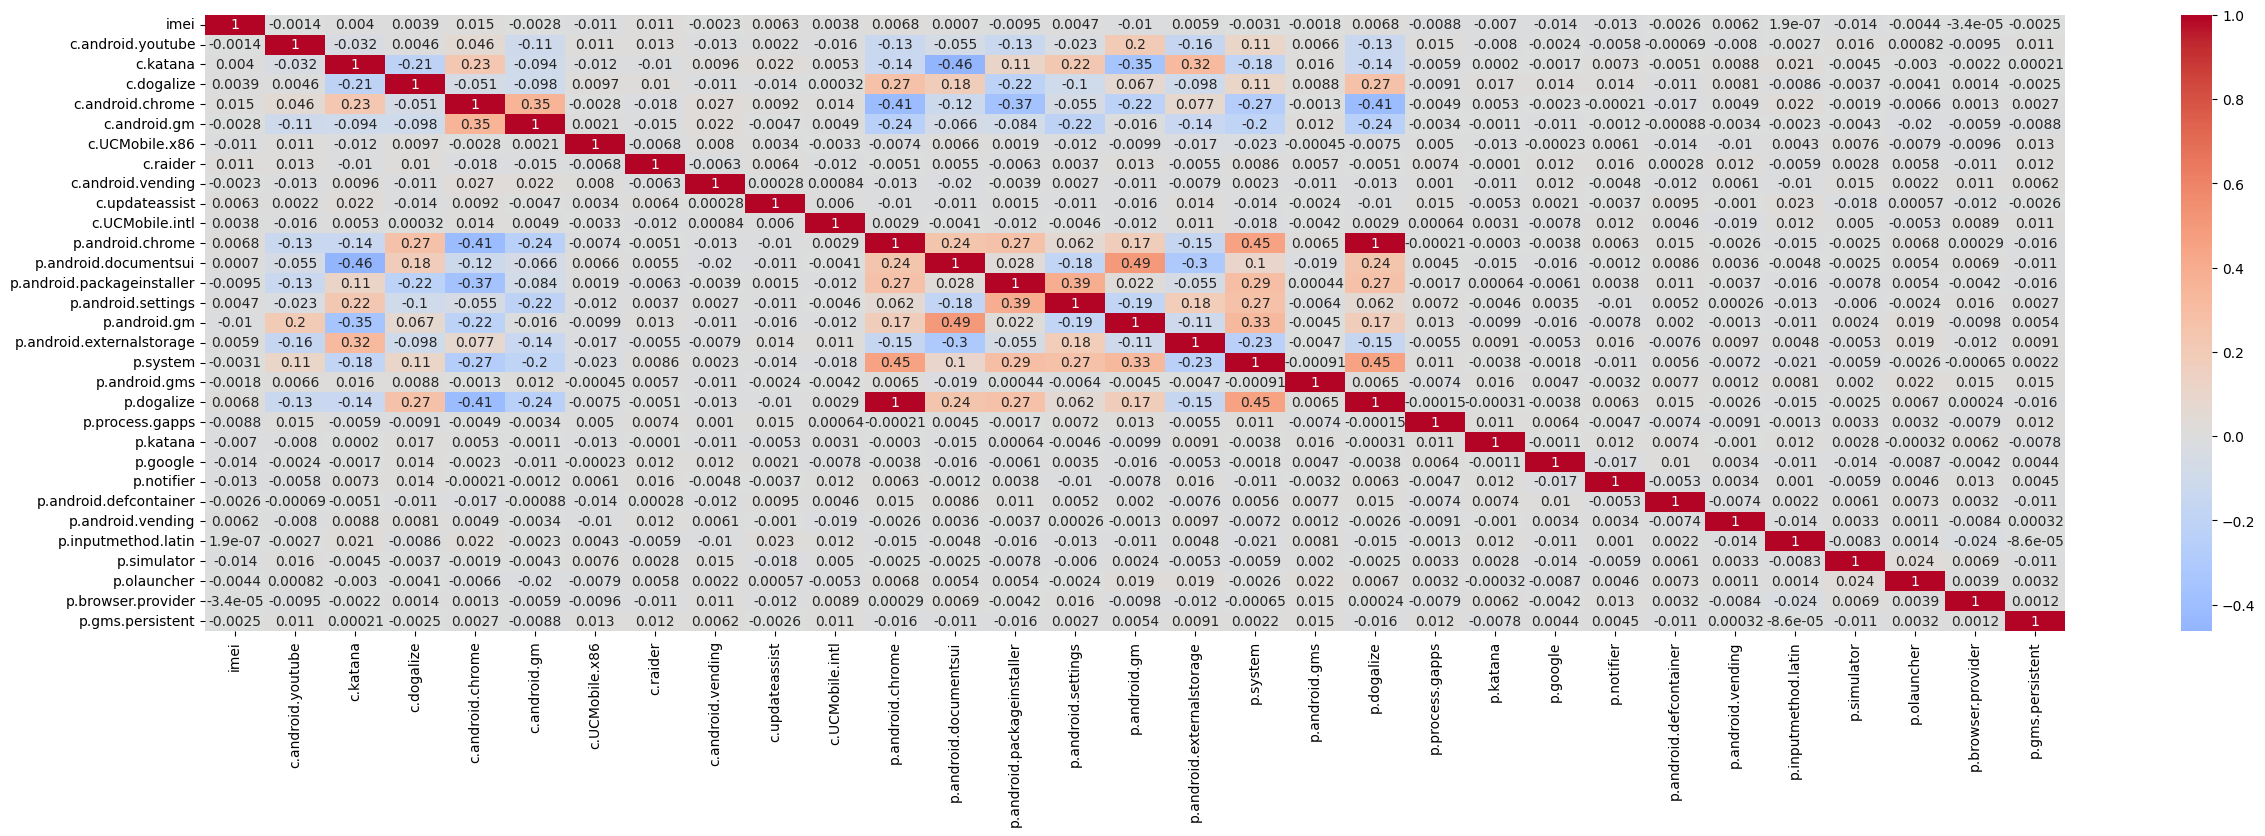

In [ ]:
# we will use correlation matrix to identify the relationship between the features and the target variable mwra
# use it for the 4 dataframes

# Vytvorenie korelačnej matice
correlation_matrix = sq_data.corr()

# Vizualizácia korelačnej matice pre zistenie vzťahu k cieľovej premennej mwra
plt.figure(figsize=(30, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

# 3. dataframe

# TS problemy
Vidime warningy ohladom konstantnych hodnotach a problem s delenim. Atributy na ktore sa libka odkazuje su rok a mesiac, takze atributy ktore sme pridali z ts. kezde je s nimi problem a uz v tomto bode si myslime ze nebudu nijak prispievat na predikovanie mwra, tak ich nebudeme na zaciatku ani pridavat do dataframu.

In [ ]:
# spájanie výsledkov do jedného DataFrame
importance_df = pd.DataFrame({
    'feature': X.columns,
    'correlation_score': correlation_matrix['mwra'].abs().drop('mwra').values,  # Korelácia s cieľovou premennou
    'random_forest_importance': rf_model.feature_importances_,  # Významnosť podľa Random Forest
    'selectkbest_score': selector.scores_  # Významnosť podľa SelectKBest
})

# Normalizácia skóre na jednotnú mierku
importance_df['correlation_score'] = importance_df['correlation_score'] / importance_df['correlation_score'].max()
importance_df['random_forest_importance'] = importance_df['random_forest_importance'] / importance_df['random_forest_importance'].max()
importance_df['selectkbest_score'] = importance_df['selectkbest_score'] / importance_df['selectkbest_score'].max()

# Vypocet dolezitosti

In [ ]:
# Priemerné skóre ako vážená dôležitosť atribútu
importance_df['average_importance'] = importance_df[['correlation_score', 'random_forest_importance', 'selectkbest_score']].mean(axis=1)

importance_df.head()

# Porovnanie vysledkov Korelacnej matice, Random forest a ANOVA testingu neformalne

todo : 

- (B-1b) Zoraďte zistené atribúty v poradí podľa dôležitosti. 


# formalne hodnotenie dolezitosti atributov

Zoradíme atribúty podľa vypočítanej priemernej dôležitosti od najdôležitejších po najmenej dôležité. Tieto atribúty predstavujú finálny výber najinformatívnejších premenných.

Ako sme uz vysie spominali, vyberieme prve tri.

In [ ]:
# Zoradenie podľa priemernej dôležitosti
importance_df = importance_df.sort_values(by='average_importance', ascending=False)

# Zobrazenie výsledkov
print(importance_df[['feature', 'average_importance']])

1. p.android.gm
2. p.android.documentsui
3. c.katana

Týmto spôsobom sme zoradili atribúty podľa ich dôležitosti pre cieľovú premennú. Atribúty s najvyšším skóre by mali byť zahrnuté v ďalšom modelovaní, pričom menej dôležité atribúty môžeme odstrániť alebo im prideliť nižšiu prioritu v ďalších analýzach.

- (C-1b) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)

# !!!!! TODO !!! TOTO ESTE SKONTROLOVAT ALEBO NEJAK PREPISAT VLASTNYMI SLOVAMI

# Zdokumentovanie a Zdôvodnenie Rozhodnutí pri Výbere a Zoradení Atribútov

Pri výbere a zoradení atribútov sme použili rôzne metódy, aby sme zabezpečili robustnosť výsledkov a optimalizovali model pre predikciu. Nižšie sú uvedené hlavné dôvody výberu použitých techník a prístupu k zoradeniu atribútov.

## 1. Kombinácia Viacerých Techník pre Výber Atribútov
- **Dôvod**: Každá metóda výberu atribútov má svoje špecifiká a klady, a preto kombinácia viacerých techník znižuje riziko nesprávneho výberu a zvýrazňuje atribúty, ktoré sú konzistentne dôležité naprieč rôznymi metódami.
- **Prístup**: Použili sme korelačnú maticu, ktorá poskytuje intuitívny a rýchly prehľad o vzťahoch medzi atribútmi a cieľovou premennou. Random Forest a SelectKBest sme pridali, pretože poskytujú pokročilejšie metódy hodnotenia dôležitosti, pričom využívajú silné stránky štatistických testov a stromových algoritmov.

## 2. Normalizácia a Výpočet Priemernej Dôležitosti
- **Dôvod**: Každá metóda používa rôzne mierky dôležitosti, preto sme výsledky zjednotili cez normalizáciu, aby boli porovnateľné. Výpočet priemernej dôležitosti umožňuje kombinovať výsledky z rôznych metód do jedného koherentného skóre, čo nám dáva spoľahlivý základ na zoradenie atribútov.
- **Prístup**: Normalizované skóre každého atribútu z jednotlivých metód sme použili na výpočet priemernej dôležitosti. Táto metóda zaručuje, že naše konečné poradie nie je ovplyvnené extrémami v jednej z metód, a súčasne zohľadňuje viaceré aspekty dôležitosti.

## 3. Zoradenie Atribútov na základe Priemernej Dôležitosti
- **Dôvod**: Zoradenie podľa priemernej dôležitosti umožňuje zamerať sa na najvýznamnejšie atribúty pri vytváraní modelu, čo vedie k efektívnejšiemu a presnejšiemu modelu.
- **Výhoda pre model**: Zahrnutím najdôležitejších atribútov zvyšujeme presnosť modelu a znižujeme šum v dátach. Na základe tohto poradia môžeme rozhodnúť o odstránení menej dôležitých atribútov, čím znížime riziko nadmerného fitovania a zvýšime generalizovateľnosť modelu.

## Celkové Zdôvodnenie
Tieto rozhodnutia boli navrhnuté s cieľom optimalizovať efektívnosť a interpretabilitu modelu. Použitím viacerých techník a váženého prístupu sme sa snažili zaistiť, že výber atribútov nie je založený na jednej metóde, ale zohľadňuje rozmanité prístupy. Týmto spôsobom sme schopní presnejšie identifikovať najinformatívnejšie atribúty, čo je kľúčové pre dosiahnutie kvalitných výsledkov v ďalšej fáze modelovania.

## 2.3 Replikovateľnosť predspracovania (5b)

- (A-3b) Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť **na predspracovanie testovacej množiny** v kontexte strojového učenia.


In [ ]:
def preprocesing(df):
    # prebehne preprocesing dataframu
    # duplikaty -> funkcia ktora odstrani duplikaty
    # missing values -> funkcia ktora ak bude menej ako 5% tak clip, ak viac tak nahradit meanom ak viac ako 40% drop cely column
    # outliers -> 
    # scaling
    # transform
    # return vyslednych preprocessed data
    pass

- (B-2b) Využite možnosti **sklearn.pipeline**

In [ ]:
temp | anoteher_def

In [ ]:
pipe(data=merged_testing, remove_duplicates, ....)